# algo **LGB**

In [ ]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import reduce
from collections import defaultdict


_size_data = 0
_dim = 0


In [ ]:
def new_codevector(c, e):
    # Cette fonction crée un nouveau vecteur de code lorsque nous diviserons en deux.
    nc = np.array(c)
    return (nc * (1.0 + e)).tolist()


In [ ]:
def avg_all_vectors(vecs, dim=None, size=None):
   
    #Cette fonction obtient la moyenne des données entières.
   
    size = size or len(vecs)
    nvec = np.array(vecs)
    nvec = nvec / size
    navg = np.sum(nvec, axis=0)
    return navg.tolist()


In [ ]:

def initial_avg_distortion(c0, data, size=None):
   
    #Cette fonction calcule la distorsion moyenne d’un vecteur par rapport à la liste d’entrée des vecteurs.
  
    size = size or _size_data
    nc = np.array(c0)
    nd = np.array(data)
    f = np.sum(((nc-nd)**2)/size)
    return f


In [ ]:
def avg_codevector_dist(c_list, data, size=None):
  
    #Cette fonction calcule la distorsion moyenne entre la liste des vecteurs et les données d’entrée.

    size = size or _size_data
    nc = np.array(c_list)
    nd = np.array(data)
    f = np.sum(((nc-nd)**2)/size)
    return f


In [ ]:
def get_mse(a, b):
    
    #Cette fonction obtient l’erreur au carré, la moyenne sera calculée plus tard.

    na = np.array(a)
    nb = np.array(b)
    return np.sum((na-nb)**2)

In [ ]:
def split_codebook(data, codebook, epsilon, initial_avg_dist):
    
    #Divisé en 2 livre de codes, obtenir le meilleur centroïde comme nouveau codevector.

    #division
    new_cv = []
    for c in codebook:
        # plus and minus epsilon for the new codebook
        c1 = new_codevector(c, epsilon)
        c2 = new_codevector(c, -epsilon)
        new_cv.extend((c1, c2))

    codebook = new_cv
    #len_codebook = len(codebook)

    # Obtenir le meilleur centroïde en prenant la distorsion moyenne comme fonction de coût. Ce problème imite K-Means.
    avg_dist = 0
    err = epsilon + 1
    #num_iter = 0
    while err > epsilon:
        # Obtenir le vecteur de code le plus proche.
        closest_c_list = [None] * _size_data    # vecteur le plus proche
        vecs_near_c = defaultdict(list)         # mappage vectoriel des données d’entrée
        vec_idxs_near_c = defaultdict(list)     # mappage de l’index des données d’entrée
        for i, vec in enumerate(data):  # for each input vector
            min_dist = None
            closest_c_index = None
            for i_c, c in enumerate(codebook):
                d = get_mse(vec, c)
                # les plus proches.
                if min_dist is None or d < min_dist:
                    min_dist = d
                    closest_c_list[i] = c
                    closest_c_index = i_c
            vecs_near_c[closest_c_index].append(vec)
            vec_idxs_near_c[closest_c_index].append(i)

        # maj du livre de code
        for i_c in range(len(codebook)):
            vecs = vecs_near_c.get(i_c) or []
            #num_vecs_near_c = len(vecs)
            if len(vecs) > 0:
                # affecter comme nouveau centre
                new_c = avg_all_vectors(vecs, _dim)
                codebook[i_c] = new_c
                for i in vec_idxs_near_c[i_c]:
                    closest_c_list[i] = new_c

                # maj des poids
                #abs_weights[i_c] = num_vecs_near_c
                #rel_weights[i_c] = num_vecs_near_c / _size_data

        # Recalculer la distorsion moyenne
        prev_avg_dist = avg_dist if avg_dist > 0 else initial_avg_dist
        avg_dist = avg_codevector_dist(closest_c_list, data)

        # Recalculer la nouvelle erreur
        err = (prev_avg_dist - avg_dist) / prev_avg_dist
        #num_iter += 1

    return codebook



In [ ]:
def generate_codebook(data, size_codebook, epsilon=0.00005):
    
    #Cette fonction générera le livre de codes en donnant les données et la taille donnée. Epsilon est le seuil qui a utilisé 
    #during fractionnement et boucle.
    
    global _size_data, _dim

    _size_data = len(data)
    #assert _size_data > 0

    _dim = len(data[0])
    #assert _dim > 0

    codebook = []
    #codebook_abs = [_size_data]
    #codebook_rel = [1.0]

    # obtenir le vecteur de code initial en prenant le vecteur moyen de données d’entrée entières
    c0 = avg_all_vectors(data, _dim, _size_data)
    codebook.append(c0)

    # distorsion moyenne initiale
    avg_dist = initial_avg_distortion(c0, data)

    # processus de fractionnement jusqu’à ce que nous ayons exactement le même nombre de codevector avec la taille du livre de codes.
    while len(codebook) < size_codebook:
        codebook = split_codebook(data, codebook,epsilon, avg_dist)
    #retourne le resulat
    return codebook
    # codebook_abs, codebook_rel


# Compression

In [ ]:
def generate_training(img, block):
    
    # génération du vecteur de code d’entraînement à partir de l’image via un patch non chevauché.

    train_vec = []
    x = block[0]
    y = block[1]
    for i in range(0, img.shape[0], x):
        for j in range(0, img.shape[1], y):
            train_vec.append(img[i:i + x, j:j + y].reshape((x * y)))
    return (np.array(train_vec))

In [ ]:
def distance(a, b):
    #Cette fonction calcule la distance (MSE) de deux vecteurs.
    return np.mean((np.subtract(a, b) ** 2))

In [ ]:
def closest_match(src, cb):
    #Cette fonction obtiendra la distance la plus proche des vecteurs comparés.
    c = np.zeros((cb.shape[0],))
    for i in range(0, cb.shape[0]):
        c[i] = distance(src, cb[i])
    minimum = np.argmin(c, axis=0)
    return minimum

In [ ]:
def encode_image(img, cb, block):
  
    #Cette fonction va encoder (compresser) l’image en envoyant le bloc d’image, le vectoriser puis obtenir l’index du 
    #vecteur le plus proche pour former les données compressées.
    
    x = block[0]
    y = block[1]
    compressed = np.zeros((img.shape[0] // y, img.shape[1] // x))
    ix = 0
    for i in range(0, img.shape[0], x):
        iy = 0
        for j in range(0, img.shape[1], y):
            src = img[i:i + x, j:j + y].reshape((x * y)).copy()
            k = closest_match(src, cb)
            compressed[ix, iy] = k
            iy += 1
        ix += 1
    return compressed

In [ ]:
def decode_image(cb, compressed, block):
    #Cette fonction décode les données compressées à l’image en prenant l’index du livre de codes puis copie le vecteur associé dans le bloc d’image.
    x = block[0]
    y = block[1]
    original = np.zeros((compressed.shape[0] * y, compressed.shape[1] * x))
    ix = 0
    for i in range(0, compressed.shape[0]):
        iy = 0
        for j in range(0, compressed.shape[1]):
            original[ix:ix + x, iy:iy + y] = cb[int(compressed[i, j])].reshape(block)
            iy += y
        ix += x
    return original

In [ ]:
def scenario(img, cb_size, epsilon, block):
    #simulation pour différents scénario; on peut agir sur la taille des block, epsilon ou le block
    train_X = generate_training(img, block)
    cb = generate_codebook(train_X, cb_size, epsilon)
    cb_n = np.array(cb)
    #cb_abs_w_n = np.array(cb_abs_w)
    #cb_rel_w_n = np.array(cb_rel_w)
    result = encode_image(img, cb_n, block)
    final_result = decode_image(cb_n, result, block)
    #fig = plt.gcf()
    #fig.set_figheight(6)
    #fig.set_figwidth(6)
    plt.imshow(result, cmap='gray')
    plt.imshow(final_result, cmap='gray')

#Simulation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


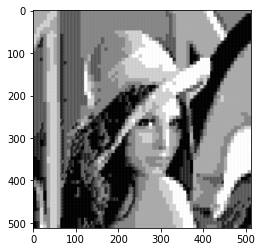

In [ ]:
img = cv2.imread('drive/My Drive/Colab Notebooks/Lenna.png', cv2.IMREAD_GRAYSCALE)
scenario(img, 8, 0.005, (8,8))

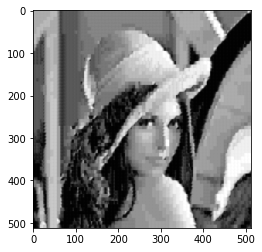

In [ ]:
scenario(img, 32, 0.005, (8,8))


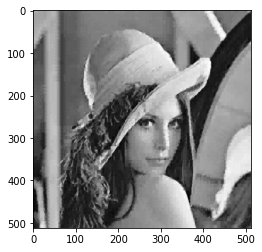

In [ ]:
scenario(img, 256, 0.005, (8,8))


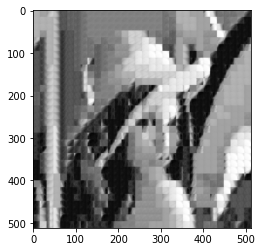

In [ ]:
scenario(img, 32, 0.005, (16,16))

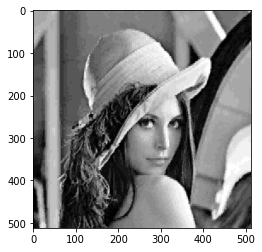

In [ ]:
scenario(img, 32, 0.005, (4,4))

In [ ]:
scenario(img, 32, 0.000005, (4,4))